pip install geopandas rasterio shapely rtree pyproj matplotlib contextily

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterstats import zonal_stats
import fiona
from rasterio.plot import show
from rasterio.mask import mask
import rasterstats
import shapely.geometry as geom
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

**Project:** Wildfire Area Restoration Priority (British Columbia, Canada)

**Goal:** Build a machine learning model to prioritize areas for ecological restoration after wildfires, combining environmental, climatic, and human-related features.

**Datasets prepared so far:**

1. **Fire perimeters:** BC wildfire dataset filtered to BC only, selected key columns (`FIRE_ID`, `YEAR`, `MONTH`, `DAY`, `SIZE_HA`, `CAUSE`, `geometry`, etc.).
2. **Land cover:** BC land cover dataset (`land_cover_BC.gpkg`), EPSG:3005, cleaned and ready.
3. **Elevation:** MRDEM 30m dataset, clipped to BC, EPSG:3005, ready.
4. **Burn severity:** `NBAC_MRB_1972to2024_30m.tif`, EPSG:3005, clipped to BC.
5. **Climate data:** Temperature (mean, max, min), precipitation, simulated relative humidity, cleaned, and missing values handled.
6. **Community proximity, watersheds, and roads:** Prepared and cleaned for feature extraction.

**Key preprocessing steps completed:**

* CRS standardized to EPSG:3005.
* Missing values handled appropriately (mean, median, or zero).
* Climate features simulated for relative humidity.
* Spatial layers clipped/reprojected to BC.
* Data types checked and ready for ML feature generation.

**Next steps for ML-ready dataset:**

1. **Feature creation / spatial joins:**

   * Distance to nearest community, road density, and watershed features.
   * Elevation and slope metrics per fire polygon.
   * Burn severity metrics aggregated per polygon (mean, max, etc.).
   * Land cover proportion per fire polygon.
   * Climate features aggregated per polygon (monthly or seasonal averages).

2. **Final ML dataset preparation:**

   * Merge all polygon-level features into a single DataFrame.
   * Encode categorical features (cause, land cover type, watershed type).
   * Normalize or scale numeric features if needed.

3. **Exploratory data analysis & correlation check:**

   * Identify collinear variables.
   * Check distributions of key features.

4. **Machine Learning modeling:**

   * Define target variable (e.g., restoration priority score).
   * Split into train/test sets.
   * Experiment with models (Random Forest, XGBoost, Gradient Boosting, etc.).
   * Evaluate model performance (accuracy, feature importance, SHAP values).

**Constraints / issues to consider:**

* Large raster datasets (DEM, burn severity) require memory-efficient operations (windowed reading or rasterio + xarray).
* Ensure all rasters are aligned in extent and resolution when performing zonal statistics.
* Keep intermediate outputs (clipped rasters, spatial joins) in compressed or optimized formats to avoid memory/disk issues.

---


## Importing fire polygons
* The fire areas are the bases to define the distances for each one of the fisical factors:
    - Land_cover
    - Roads
    - Wateshed
    - Community proximity
    - Elevation
* Also the fire impact factors:
    - Burn Severity
    - Climate

In [2]:
fires_fp = "../data_raw/fire_perimeters/fire_perimeters.gpkg"
fires = gpd.read_file(fires_fp)
# fires = fires.to_crs("EPSG:3005")  # ensure same CRS as rasters
fires.columns

Index(['FIRE_ID', 'YEAR', 'MONTH', 'DAY', 'REP_DATE', 'SIZE_HA', 'CALC_HA',
       'CAUSE', 'MAP_METHOD', 'POLY_DATE', 'geometry'],
      dtype='object')

In [3]:
print("max", fires['YEAR'].max())
print("min", fires['YEAR'].min())


max 2020
min 1917


In [ ]:
fire.head()

,FIRE_ID,YEAR,MONTH,DAY,REP_DATE,SIZE_HA,CALC_HA,CAUSE,MAP_METHOD,POLY_DATE,geometry
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,"MULTIPOLYGON Z (((1101470.06 895987.632 0, 110..."
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,"MULTIPOLYGON Z (((1059622.287 791392.109 0, 10..."
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,"MULTIPOLYGON Z (((1016741.687 807717.542 0, 10..."
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,"MULTIPOLYGON Z (((982266.652 887925.07 0, 9823..."


In [5]:
fires.tail()

,FIRE_ID,YEAR,MONTH,DAY,REP_DATE,SIZE_HA,CALC_HA,CAUSE,MAP_METHOD,POLY_DATE,geometry
21245,2020-V61168,2020,8,16,2020-08-16,5.4,5.404308,L,Non-corrected ground GPS,NaT,"MULTIPOLYGON Z (((1167809.019 393815.911 0, 11..."
21246,2020-V61178,2020,8,17,2020-08-17,1.1,1.060708,L,Non-corrected ground GPS,NaT,"MULTIPOLYGON Z (((1164213.303 383887.314 0, 11..."
21247,2020-V61180,2020,8,16,2020-08-16,2.2,2.167941,L,Non-corrected ground GPS,NaT,"MULTIPOLYGON Z (((1168238.738 396597.748 0, 11..."
21248,2020-V61184,2020,8,16,2020-08-16,1.7,1.686820,L,Non-corrected ground GPS,NaT,"MULTIPOLYGON Z (((1153667.161 379914.656 0, 11..."
21249,2020-V61194,2020,8,16,2020-08-16,0.7,0.747240,L,Non-corrected ground GPS,NaT,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."


In [ ]:
# def extract_raster_stats(raster_fp, polygons_gdf, stats=["mean", "max", "min"]):
#     """
#     Extract raster statistics per polygon.
    
#     Returns a DataFrame with one row per polygon.
#     """
#     out_stats = rasterstats.zonal_stats(
#         vectors=polygons_gdf,
#         raster=raster_fp,
#         stats=stats,
#         geojson_out=False,
#         nodata=None  # handle nodata if needed
#     )
#     df_stats = pd.DataFrame(out_stats)
#     return df_stats



In [6]:
climate_gdf = gpd.read_file("../data_raw/climate/climate_EPSG_HR.gpkg")
climate_gdf.head()

,Tm,Tx,Tn,P,S,S_G,Year,Month,Long,Lat,RH,geometry
0,4.7,13.0,-5.5,546.6,53.8,0.0,2020,1,-123.742,48.935,55.20,POINT (1165636.462 438056.769)
1,10.0,23.7,-6.0,15.0,0.0,0.0,2020,4,-121.934,50.684,46.24,POINT (1286985.38 638142.245)
2,9.6,23.2,-6.4,17.9,0.0,0.0,2020,4,-121.582,50.224,46.32,POINT (1314992.12 588535.267)
3,9.8,23.9,-6.4,15.9,0.0,0.0,2020,4,-121.582,50.224,45.76,POINT (1314992.12 588535.267)
4,4.4,21.0,-15.0,16.4,1.0,0.0,2020,4,-120.333,49.673,41.20,POINT (1408773.898 533790.485)


In [5]:
climate_gdf.columns

Index(['Tm', 'Tx', 'Tn', 'P', 'S', 'S_G', 'Year', 'Month', 'Long', 'Lat', 'RH',
       'geometry'],
      dtype='object')

### Fire-Climate relations __(Spatial join)__
* The climate will be joined based on the average humidity, temperature and precipitation per coordinate

Rename fire columns


In [7]:
fires = fires.rename(columns={
    "FIRE_ID": "fire_id",
    "YEAR": "fire_year",
    "MONTH": "fire_month",
    "DAY": "fire_day",
    "REP_DATE": "fire_rep_date",
    "SIZE_HA": "fire_size_ha",
    "CALC_HA": "fire_calc_ha",
    "CAUSE": "fire_cause",
    "MAP_METHOD": "fire_map_method",
    "POLY_DATE": "fire_poly_date",
})

Rename climate columns


In [8]:
climate_gdf = climate_gdf.rename(columns={
    "Long": "climate_long",
    "Lat": "climate_lat",
    "Tm": "climate_Tm",
    "Tx": "climate_Tx",
    "Tn": "climate_Tn",
    "P": "climate_P",
    "S": "climate_S",
    "S_G": "climate_SG",
    "RH": "climate_RH"
})

In [76]:
print(fires.columns)

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'geometry'],
      dtype='object')


In [134]:
print(climate_gdf.columns)

Index(['climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'Year', 'Month', 'climate_long', 'climate_lat',
       'climate_RH', 'geometry'],
      dtype='object')


In [135]:
climate_gdf.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Spatial join for fire perimeters and climate data

In [10]:

# If coordinates are in columns Long, Lat
climate_gdf_all_stations = gpd.GeoDataFrame(
    climate_gdf,
    geometry=gpd.points_from_xy(climate_gdf['climate_long'], climate_gdf['climate_lat']),
    crs="EPSG:3005"  # match your fire polygons CRS
)


In [9]:
minx, miny, maxx, maxy = fires.total_bounds
climate_gdf = climate_gdf.cx[minx:maxx, miny:maxy]

In [ ]:
# fire_climate = gpd.sjoin_nearest(
#     fires,
#     climate_gdf,
#     how="left",
#     distance_col="dist_to_station"
# )


In [18]:
fire_climate[['fire_id', 'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_RH', 'dist_to_station']].head()

,fire_id,climate_Tm,climate_Tx,climate_Tn,climate_P,climate_RH,dist_to_station
0,2004-C10175,11.7,26.9,-3.1,29.8,46.00,108574.81812
0,2004-C10175,16.0,34.5,0.4,10.3,42.72,108574.81812
0,2004-C10175,16.8,32.9,-1.0,2.4,42.88,108574.81812
0,2004-C10175,6.4,27.3,-12.3,6.8,38.32,108574.81812
0,2004-C10175,-3.3,9.3,-16.8,25.2,49.12,108574.81812


In [19]:
fire_climate.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'geometry', 'index_right', 'climate_Tm', 'climate_Tx',
       'climate_Tn', 'climate_P', 'climate_S', 'climate_SG', 'Year', 'Month',
       'climate_long', 'climate_lat', 'climate_RH', 'dist_to_station'],
      dtype='object')

In [ ]:
# fire_climate.to_file("../outputs/fires_climate.gpkg", driver="GPKG")

In [21]:
f_c = gpd.read_file("../outputs/fires_climate.gpkg")
f_c.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_P,climate_S,climate_SG,Year,Month,climate_long,climate_lat,climate_RH,dist_to_station,geometry
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,29.8,0.0,0.0,2020,6,-124.136,52.114,46.00,108574.81812,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
1,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,10.3,0.0,0.0,2024,7,-124.136,52.114,42.72,108574.81812,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
2,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,2.4,0.0,0.0,2021,7,-124.136,52.114,42.88,108574.81812,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
3,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,6.8,0.0,0.0,2022,10,-124.136,52.114,38.32,108574.81812,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
4,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,25.2,0.0,1.0,2023,11,-124.136,52.114,49.12,108574.81812,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."


In [22]:
f_c.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
index_right        13853
climate_Tm           453
climate_Tx           460
climate_Tn           588
climate_P           2698
climate_S            600
climate_SG           184
Year                   6
Month                 12
climate_long         225
climate_lat          216
climate_RH           684
dist_to_station    21193
geometry           21238
dtype: int64

In [23]:
f_c.tail()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_P,climate_S,climate_SG,Year,Month,climate_long,climate_lat,climate_RH,dist_to_station,geometry
1360160,2020-V61194,2020,8,16,2020-08-16,0.7,0.74724,L,Non-corrected ground GPS,NaT,...,53.7,0.0,0.0,2020,5,-123.87,49.054,48.88,13444.774667,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."
1360161,2020-V61194,2020,8,16,2020-08-16,0.7,0.74724,L,Non-corrected ground GPS,NaT,...,46.3,0.0,0.0,2020,5,-123.87,49.054,49.20,13444.774667,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."
1360162,2020-V61194,2020,8,16,2020-08-16,0.7,0.74724,L,Non-corrected ground GPS,NaT,...,53.7,0.0,0.0,2022,5,-123.87,49.054,52.80,13444.774667,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."
1360163,2020-V61194,2020,8,16,2020-08-16,0.7,0.74724,L,Non-corrected ground GPS,NaT,...,229.9,2.0,0.0,2021,1,-123.87,49.054,55.60,13444.774667,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."
1360164,2020-V61194,2020,8,16,2020-08-16,0.7,0.74724,L,Non-corrected ground GPS,NaT,...,53.7,0.0,0.0,2023,9,-123.87,49.054,50.48,13444.774667,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11..."


### Fire-Roads distances __(spatial index)__

In [ ]:
# Load roads
roads = gpd.read_file("../data_raw/roads/roads_BC.gpkg")

In [23]:
roads.head()

,NGD_UID,CLASS,geometry
0,107215,23,"LINESTRING (1187054.303 401928.001, 1187047.09..."
1,2910067,23,"LINESTRING (1076598.102 519287.903, 1076519.59..."
2,4409173,29,"LINESTRING (1271948.102 453261.799, 1271949.99..."
3,5888173,26,"LINESTRING (1286865.199 647664.555, 1286963.45..."
4,4507098,21,"LINESTRING (1318502.402 1260924.759, 1318487.6..."


In [25]:
roads.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

##### Computing fire distance to nearest road

In [25]:
fire_climate = fire_climate.rename(columns={"index_right": "climate_index"})

In [26]:
fire_climate.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'geometry', 'climate_index', 'climate_Tm',
       'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S', 'climate_SG',
       'Year', 'Month', 'climate_long', 'climate_lat', 'climate_RH',
       'dist_to_station'],
      dtype='object')

In [37]:
fire_climate.shape

(21250, 22)

In [ ]:
# Nearest road distance for each fire polygon

nearest_roads = gpd.sjoin_nearest(
    fire_climate, roads,
    how="left",
    distance_col="dist_roads"
)

# Ensure indices match by resetting
fire_climate = fire_climate.reset_index(drop=True)
nearest_roads = nearest_roads.reset_index(drop=True)

# Now you can safely assign
fire_climate["dist_roads"] = nearest_roads["dist_roads"]

In [39]:
fire_climate.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'geometry', 'climate_index', 'climate_long',
       'climate_lat', 'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P',
       'climate_S', 'climate_SG', 'climate_RH', 'dist_to_station',
       'dist_roads'],
      dtype='object')

In [40]:
fire_climate.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_lat,climate_Tm,climate_Tx,climate_Tn,climate_P,climate_S,climate_SG,climate_RH,dist_to_station,dist_roads
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,49.833,5.191176,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.409991e+06,3192.539792
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,49.833,5.191176,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.419139e+06,2430.474664
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,49.833,5.191176,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.320938e+06,4454.299165
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,49.833,5.191176,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.289444e+06,4462.261485
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,58.841,0.975000,18.114706,-14.520588,30.457353,0.0,18.058824,43.597647,1.313769e+06,32945.953067


In [41]:
f_cl_r = fire_climate

f_cl_r.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [42]:
f_cl_r.to_file("../outputs/fires_climate_roads.gpkg", driver="GPKG")

### Fire-Watershed distance __(overlap percentage)__

In [45]:
watershed = gpd.read_file("../data_raw/watershed/watersheds_EPSG.gpkg")


In [47]:
watershed.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [46]:
watershed.columns

Index(['WATERSHED_FEATURE_ID', 'FWA_WATERSHED_CODE', 'WATERSHED_ORDER',
       'AREA_HA', 'WATERSHED_GROUP_CODE', 'geometry'],
      dtype='object')

In [50]:
# Overlay with watersheds
f_cl_r_w = gpd.overlay(f_cl_r, watershed, how="intersection")

# Overlap stats
f_cl_r_w["overlap_area"] = f_cl_r_w.geometry.area
f_cl_r_w["overlap_pct"] = (
    f_cl_r_w["overlap_area"] /
    f_cl_r_w.groupby("fire_id")["overlap_area"].transform("sum")
)

# Aggregate to max overlap per fire
watershed_stats = f_cl_r_w.groupby("fire_id")["overlap_pct"].max().reset_index()

# Merge back into enriched fires dataset
f_cl_r = f_cl_r.merge(watershed_stats, on="fire_id", how="left")

# Save
f_cl_r.to_file("../outputs/fires_climate_roads_watershed.gpkg", driver="GPKG")


c:\Users\Dell\anaconda3\envs\fire_env\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 730 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [51]:
f_cl_r_w = gpd.read_file("../outputs/fires_climate_roads_watershed.gpkg")
f_cl_r_w.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_Tx,climate_Tn,climate_P,climate_S,climate_SG,climate_RH,dist_to_station,dist_roads,overlap_pct,geometry
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.409991e+06,3192.539792,0.162133,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10..."
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.419139e+06,2430.474664,0.451413,"MULTIPOLYGON Z (((1101470.06 895987.632 0, 110..."
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.320938e+06,4454.299165,0.611898,"MULTIPOLYGON Z (((1059622.287 791392.109 0, 10..."
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,20.227941,-10.633824,53.700000,0.0,0.000000,45.310588,1.289444e+06,4462.261485,0.011481,"MULTIPOLYGON Z (((1016741.687 807717.542 0, 10..."
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,18.114706,-14.520588,30.457353,0.0,18.058824,43.597647,1.313769e+06,32945.953067,0.069338,"MULTIPOLYGON Z (((982266.652 887925.07 0, 9823..."


In [52]:
f_cl_r_w.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long', 'climate_lat',
       'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'climate_RH', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'geometry'],
      dtype='object')

* Higher overlap_pct → higher potential impact on water resources → the fire may be more relevant for restoration prioritization in terms of protecting or recovering watersheds.

* Lower overlap_pct → less overlap → smaller potential impact.

In [58]:
f_cl_r_w.shape

(21250, 24)

### Fire-Communities distance

In [59]:
communities = gpd.read_file("../data_raw/community_prox/com_prox_epgs.gpkg")

In [60]:
communities.columns

Index(['AA_NAME', 'AA_LOC_TYP', 'geometry'], dtype='object')

In [61]:
communities.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [62]:
# Run nearest join
nearest_comm = gpd.sjoin_nearest(
    f_cl_r_w,
    communities,
    how="left",
    distance_col="dist_community"
)

In [63]:
# Keep only one nearest community per fire_id (smallest distance)
dist_comm = (
    nearest_comm.groupby("fire_id")["dist_community"]
    .min()
    .reset_index()
)

In [ ]:
# Merge back to your main GeoDataFrame
f_cl_r_w_com = f_cl_r_w.merge(dist_comm, on="fire_id", how="left")

In [73]:
f_cl_r_w_com.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long', 'climate_lat',
       'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'climate_RH', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'geometry', 'dist_community'],
      dtype='object')

In [70]:
# Drop the old one and keep only the merged version
f_cl_r_w_com = f_cl_r_w_com.drop(columns=["dist_community_x"])
f_cl_r_w_com = f_cl_r_w_com.rename(columns={"dist_community_y": "dist_community"})

In [71]:
f_cl_r_w_com.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_Tn,climate_P,climate_S,climate_SG,climate_RH,dist_to_station,dist_roads,overlap_pct,geometry,dist_community
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,-10.633824,53.700000,0.0,0.000000,45.310588,1.409991e+06,3192.539792,0.162133,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10...",23505.955950
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,-10.633824,53.700000,0.0,0.000000,45.310588,1.419139e+06,2430.474664,0.451413,"MULTIPOLYGON Z (((1101470.06 895987.632 0, 110...",29042.845746
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,-10.633824,53.700000,0.0,0.000000,45.310588,1.320938e+06,4454.299165,0.611898,"MULTIPOLYGON Z (((1059622.287 791392.109 0, 10...",22410.081120
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,-10.633824,53.700000,0.0,0.000000,45.310588,1.289444e+06,4462.261485,0.011481,"MULTIPOLYGON Z (((1016741.687 807717.542 0, 10...",0.000000
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,-14.520588,30.457353,0.0,18.058824,43.597647,1.313769e+06,32945.953067,0.069338,"MULTIPOLYGON Z (((982266.652 887925.07 0, 9823...",2492.124558


In [74]:
f_cl_r_w_com.to_file("../outputs/fires_climate_roads_watershed_community.gpkg", driver="GPKG")

### Fire-Elevation __(Raster Zonal stats)__

A small fire in a valley will have a low elevation_mean.

A large fire covering mountains and valleys will average those out.

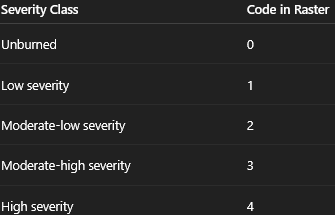

In [82]:
f_cl_r_w_com[["elevation_min", "elevation_max", "elevation_mean", "elevation_std"]] = f_cl_r_w_com.apply(
    lambda row: pd.Series(
        rasterstats.zonal_stats(
            row.geometry,
            "../data_raw/elevation/dem_bc_clipped_epsg3005.tif",
            stats="min max mean std"
        )[0]
    ),
    axis=1
)


In [83]:
f_cl_r_w_com_ele = f_cl_r_w_com
f_cl_r_w_com_ele.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_RH,dist_to_station,dist_roads,overlap_pct,geometry,dist_community,elevation_mean,elevation_min,elevation_max,elevation_std
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,45.310588,1.409991e+06,3192.539792,0.162133,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10...",23505.955950,1.0,1.0,1.0,0.0
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,45.310588,1.419139e+06,2430.474664,0.451413,"MULTIPOLYGON Z (((1101470.06 895987.632 0, 110...",29042.845746,1.0,1.0,1.0,0.0
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,45.310588,1.320938e+06,4454.299165,0.611898,"MULTIPOLYGON Z (((1059622.287 791392.109 0, 10...",22410.081120,1.0,1.0,1.0,0.0
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,45.310588,1.289444e+06,4462.261485,0.011481,"MULTIPOLYGON Z (((1016741.687 807717.542 0, 10...",0.000000,1.0,1.0,1.0,0.0
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,43.597647,1.313769e+06,32945.953067,0.069338,"MULTIPOLYGON Z (((982266.652 887925.07 0, 9823...",2492.124558,1.0,1.0,1.0,0.0


In [23]:
f_cl_r_w_com_ele.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long', 'climate_lat',
       'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'climate_RH', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'geometry'],
      dtype='object')

In [85]:
f_cl_r_w_com_ele.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [86]:
f_cl_r_w_com_ele.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
climate_long           2
climate_lat            2
climate_Tm             2
climate_Tx             2
climate_Tn             2
climate_P              2
climate_S              1
climate_SG             2
climate_RH             2
dist_to_station    21220
dist_roads          4751
overlap_pct        16204
geometry           21238
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
dtype: int64

In [87]:
f_cl_r_w_com_ele.to_file(
    "../outputs/fire_climate_roads_watershed_community_elevation.gpkg",
    layer="fire_polygons_env",
    driver="GPKG"
)

In [10]:
f_cl_r_w_com_ele = gpd.read_file("../outputs/fire_climate_roads_watershed_community_elevation.gpkg")

### Fire-Burn_severity __(Raster Zonal stats)__

__Burn severity is calculated (ecology + remote sensing side)__

burnsev_mean → average severity of the fire across its perimeter (higher = more severe overall).

burnsev_max → worst-case severity spot inside that polygon.

burnsev_min → areas inside the polygon with low/no severity.

burnsev_std → tells you whether severity was uniform or patchy (high variation = some areas were badly burned, others not).

In [27]:
from osgeo import gdal

ds = gdal.Open("../data_raw/burn_severity/burn_severity_bc_clipped_fires.tif")
burnsev_info = gdal.Info(ds, format="json")

# See the top-level keys
print(burnsev_info.keys())

# Check what is inside the first band
print(burnsev_info["bands"][0].keys())

# Then you can check min/max/nodata values
print("NoData value:", burnsev_info["bands"][0].get("noDataValue"))
print("Min / Max values:", burnsev_info["bands"][0].get("minimum"), burnsev_info["bands"][0].get("maximum"))


dict_keys(['description', 'driverShortName', 'driverLongName', 'files', 'size', 'coordinateSystem', 'geoTransform', 'metadata', 'cornerCoordinates', 'wgs84Extent', 'bands', 'stac'])
dict_keys(['band', 'block', 'type', 'colorInterpretation', 'noDataValue', 'metadata'])
NoData value: 65535.0
Min / Max values: None None


In [29]:
stats = zonal_stats(
    f_cl_r_w_com_ele.geometry,
    "../data_raw/burn_severity/burn_severity_bc_clipped_fires.tif",
    stats=["min", "max", "mean", "std"],
    nodata=65535
)

In [13]:
f_cl_r_w_com_ele[["burnsev_min", "burnsev_max", "burnsev_mean", "burnsev_std"]] = f_cl_r_w_com_ele.apply(
    lambda row: pd.Series(
        rasterstats.zonal_stats(
            row.geometry,
            "../data_raw/burn_severity/burn_severity_bc_clipped_fires.tif",
            stats="min max mean std"
        )[0]
    ),
    axis=1
)

In [14]:
f_cl_r_w_com_ele.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long', 'climate_lat',
       'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'climate_RH', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'geometry', 'burnsev_min',
       'burnsev_max', 'burnsev_mean', 'burnsev_std'],
      dtype='object')

In [15]:
f_cl_r_w_com_ele.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
climate_long           2
climate_lat            2
climate_Tm             2
climate_Tx             2
climate_Tn             2
climate_P              2
climate_S              1
climate_SG             2
climate_RH             2
dist_to_station    21220
dist_roads          4751
overlap_pct        16204
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
geometry           21238
burnsev_min           51
burnsev_max           50
burnsev_mean        1334
burnsev_std         1292
dtype: int64

In [16]:
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele
f_cl_r_w_com_ele_bs.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,dist_community,elevation_mean,elevation_min,elevation_max,elevation_std,geometry,burnsev_min,burnsev_max,burnsev_mean,burnsev_std
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,23505.955950,1.0,1.0,1.0,0.0,"MULTIPOLYGON Z (((1092870.828 897955.996 0, 10...",1998.0,1998.0,1998.0,0.0
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,29042.845746,1.0,1.0,1.0,0.0,"MULTIPOLYGON Z (((1101470.06 895987.632 0, 110...",NaN,NaN,NaN,NaN
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,22410.081120,1.0,1.0,1.0,0.0,"MULTIPOLYGON Z (((1059622.287 791392.109 0, 10...",NaN,NaN,NaN,NaN
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,0.000000,1.0,1.0,1.0,0.0,"MULTIPOLYGON Z (((1016741.687 807717.542 0, 10...",NaN,NaN,NaN,NaN
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,2492.124558,1.0,1.0,1.0,0.0,"MULTIPOLYGON Z (((982266.652 887925.07 0, 9823...",NaN,NaN,NaN,NaN


In [123]:
f_cl_r_w_com_ele_bs.tail()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,geometry,dist_community,elevation_mean,elevation_min,elevation_max,elevation_std,burnsev_min,burnsev_max,burnsev_mean,burnsev_std
21245,2020-V61168,2020,8,16,2020-08-16,5.4,5.404308,L,Non-corrected ground GPS,NaT,...,"MULTIPOLYGON Z (((1167809.019 393815.911 0, 11...",10875.326242,1.0,1.0,1.0,0.0,2023.0,2023.0,2023.0,0.0
21246,2020-V61178,2020,8,17,2020-08-17,1.1,1.060708,L,Non-corrected ground GPS,NaT,...,"MULTIPOLYGON Z (((1164213.303 383887.314 0, 11...",13506.875812,1.0,1.0,1.0,0.0,2023.0,2023.0,2023.0,0.0
21247,2020-V61180,2020,8,16,2020-08-16,2.2,2.167941,L,Non-corrected ground GPS,NaT,...,"MULTIPOLYGON Z (((1168238.738 396597.748 0, 11...",10299.349448,1.0,1.0,1.0,0.0,2023.0,2023.0,2023.0,0.0
21248,2020-V61184,2020,8,16,2020-08-16,1.7,1.686820,L,Non-corrected ground GPS,NaT,...,"MULTIPOLYGON Z (((1153667.161 379914.656 0, 11...",22941.023569,1.0,1.0,1.0,0.0,2023.0,2023.0,2023.0,0.0
21249,2020-V61194,2020,8,16,2020-08-16,0.7,0.747240,L,Non-corrected ground GPS,NaT,...,"MULTIPOLYGON Z (((1149356.342 439168.304 0, 11...",8310.543855,1.0,1.0,1.0,0.0,2023.0,2023.0,2023.0,0.0


In [15]:
f_cl_r_w_com_ele_bs.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
climate_long           2
climate_lat            2
climate_Tm             2
climate_Tx             2
climate_Tn             2
climate_P              2
climate_S              1
climate_SG             2
climate_RH             2
dist_to_station    21220
dist_roads          4751
overlap_pct        16204
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
geometry           21238
dtype: int64

In [ ]:
f_cl_r_w_com_ele_bs.to_file("../outputs/fire_climate_roads_watershed_community_elevation_burnsev.gpkg")

---

### Adjusting climate data (normalization didn't work as expected)

In [13]:
f_cl_r_w_com_ele_bs = gpd.read_file("../outputs/fire_climate_roads_watershed_community_elevation_burnsev.gpkg")

In [18]:
f_cl_r_w_com_ele_bs.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long', 'climate_lat',
       'climate_Tm', 'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S',
       'climate_SG', 'climate_RH', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'geometry', 'burnsev_min',
       'burnsev_max', 'burnsev_mean', 'burnsev_std'],
      dtype='object')

In [ ]:
# f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.rename(columns={
#     "index_right": "general_index"
# })

In [14]:
fires_centroids = f_cl_r_w_com_ele_bs.copy()
fires_centroids["geometry"] = fires_centroids.centroid

In [15]:
import numpy as np
from scipy.spatial import cKDTree

# Extract coordinates
fire_coords = np.array(list(zip(fires_centroids.geometry.x, fires_centroids.geometry.y)))
climate_coords = np.array(list(zip(climate_gdf.geometry.x, climate_gdf.geometry.y)))

# Build KDTree and query
tree = cKDTree(climate_coords)
distances, indices = tree.query(fire_coords, k=1)


NameError: name 'climate_gdf' is not defined

In [21]:
fires_centroids["dist_to_station"] = distances
fires_centroids["nearest_station_id"] = climate_gdf.iloc[indices].index.values

In [22]:
# Drop geometry from climate_gdf to avoid CRS conflicts
climate_attrs = climate_gdf.drop(columns="geometry")

# Merge by nearest station
f_cl_r_w_com_ele_bs = fires_centroids.merge(
    climate_attrs,
    left_on="nearest_station_id",
    right_index=True,
    how="left"
)

# Clean up helper column if you don’t need it
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.drop(columns=["nearest_station_id"])


In [23]:
f_cl_r_w_com_ele_bs.head()

,fire_id,fire_year,fire_month,fire_day,fire_rep_date,fire_size_ha,fire_calc_ha,fire_cause,fire_map_method,fire_poly_date,...,climate_Tx_y,climate_Tn_y,climate_P_y,climate_S_y,climate_SG_y,Year,Month,climate_long_y,climate_lat_y,climate_RH_y
0,2004-C10175,2004,6,23,2004-06-23,1370.5,1370.507344,L,digitized,2007-05-17,...,28.2,-5.3,17.1,0.0,0.0,2025,5,-124.136,52.114,43.20
1,2004-C10176,2004,6,23,2004-06-23,520.7,520.796287,L,digitized,2007-05-17,...,28.2,-5.3,17.1,0.0,0.0,2025,5,-124.136,52.114,43.20
2,2004-C50114,2004,6,20,2004-06-20,268.2,268.290572,L,digitized,2007-05-17,...,28.2,-5.3,17.1,0.0,0.0,2025,5,-124.136,52.114,43.20
3,2004-C50125,2004,6,21,2004-06-21,20506.4,20506.415129,L,Modified from Protection,2007-05-17,...,27.1,4.2,80.5,0.0,0.0,2020,6,-126.587,52.389,51.68
4,2004-C50149,2004,6,22,2004-06-22,2408.5,2408.587142,L,digitized,2007-05-17,...,27.1,4.2,80.5,0.0,0.0,2020,6,-126.587,52.389,51.68


In [24]:
f_cl_r_w_com_ele_bs.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'climate_long_x', 'climate_lat_x',
       'climate_Tm_x', 'climate_Tx_x', 'climate_Tn_x', 'climate_P_x',
       'climate_S_x', 'climate_SG_x', 'climate_RH_x', 'dist_to_station',
       'dist_roads', 'overlap_pct', 'dist_community', 'elevation_mean',
       'elevation_min', 'elevation_max', 'elevation_std', 'geometry',
       'burnsev_min', 'burnsev_max', 'burnsev_mean', 'burnsev_std',
       'climate_Tm_y', 'climate_Tx_y', 'climate_Tn_y', 'climate_P_y',
       'climate_S_y', 'climate_SG_y', 'Year', 'Month', 'climate_long_y',
       'climate_lat_y', 'climate_RH_y'],
      dtype='object')

In [25]:
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.drop(
    columns=[col for col in f_cl_r_w_com_ele_bs.columns if col.endswith("_x")]
)
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.rename(
    columns=lambda c: c.replace("_y", "") if c.endswith("_y") else c
)

In [26]:
f_cl_r_w_com_ele_bs.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'geometry', 'burnsev_min',
       'burnsev_max', 'burnsev_mean', 'burnsev_std', 'climate_Tm',
       'climate_Tx', 'climate_Tn', 'climate_P', 'climate_S', 'climate_SG',
       'Year', 'Month', 'climate_long', 'climate_lat', 'climate_RH'],
      dtype='object')

In [27]:
f_cl_r_w_com_ele.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
climate_long           2
climate_lat            2
climate_Tm             2
climate_Tx             2
climate_Tn             2
climate_P              2
climate_S              1
climate_SG             2
climate_RH             2
dist_to_station    21220
dist_roads          4751
overlap_pct        16204
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
geometry           21238
burnsev_min           51
burnsev_max           50
burnsev_mean        1334
burnsev_std         1292
dtype: int64

In [16]:
f_cl_r_w_com_ele_bs.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
dist_to_station    21238
dist_roads          4751
overlap_pct        16204
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
burnsev_min           51
burnsev_max           50
burnsev_mean        1334
burnsev_std         1292
climate_Tm           151
climate_Tx           132
climate_Tn           137
climate_P            183
climate_S             43
climate_SG            26
Year                   6
Month                 12
climate_long         225
climate_lat          216
climate_RH           128
geometry           21238
dtype: int64

In [29]:
f_cl_r_w_com_ele_bs.to_file("../outputs/fire_climate_roads_watershed_community_elevation_burnsev.gpkg")

In [17]:
f_cl_r_w_com_ele_bs = gpd.read_file("../outputs/fire_climate_roads_watershed_community_elevation_burnsev.gpkg")
f_cl_r_w_com_ele_bs.nunique()

fire_id            18558
fire_year            104
fire_month            12
fire_day              31
fire_rep_date       7332
fire_size_ha        6418
fire_calc_ha       21238
fire_cause             4
fire_map_method       73
fire_poly_date      1161
climate_index          2
dist_to_station    21238
dist_roads          4751
overlap_pct        16204
dist_community     18275
elevation_mean      1253
elevation_min         10
elevation_max         10
elevation_std       1257
burnsev_min           51
burnsev_max           50
burnsev_mean        1334
burnsev_std         1292
climate_Tm           151
climate_Tx           132
climate_Tn           137
climate_P            183
climate_S             43
climate_SG            26
Year                   6
Month                 12
climate_long         225
climate_lat          216
climate_RH           128
geometry           21238
dtype: int64

#### End of climate adjustment

---

#### Combinating all environmental factors
* Inserting burn severity on __f_cl_r_w_com_ele_bs__
* Preparing to insert the __land cover data__

### Fire-Land_Cover __(Overlays)__

In [7]:
landcover = gpd.read_file("../data_raw/land_cover/land_cover_BC.gpkg")

In [8]:
landcover.crs

<Projected CRS: EPSG:3005>
Name: NAD83 / BC Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - British Columbia.
- bounds: (-139.04, 48.25, -114.08, 60.01)
Coordinate Operation:
- name: British Columbia Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
landcover.total_bounds

array([ 718133.775,  447243.043, 1801421.88 , 1187259.169])

In [62]:
landcover.columns

Index(['THRLNDCVR2', 'LNDCVRCLSS', 'OBJECTID', 'AREA_SQM', 'FEAT_LEN',
       'geometry'],
      dtype='object')

In [9]:
# Ensure fire polygons have a unique ID as a normal column
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.reset_index(drop=True)
f_cl_r_w_com_ele_bs["fire_id"] = f_cl_r_w_com_ele_bs.index

Because just a few __land cover__ boundaries are intersecting with the fire polygons, I'm going to use 
* __spatial nearest-neighbor assignment__

In [18]:
import geopandas as gpd
from shapely.geometry import Point

# Ensure CRS match
f_cl_r_w_com_ele_bs = f_cl_r_w_com_ele_bs.to_crs(landcover.crs)

# Compute fire centroids
f_cl_r_w_com_ele_bs["fire_centroid"] = f_cl_r_w_com_ele_bs.geometry.centroid

# Create a GeoDataFrame of centroids
fire_points = gpd.GeoDataFrame(
    f_cl_r_w_com_ele_bs[["fire_id"]],
    geometry=f_cl_r_w_com_ele_bs["fire_centroid"],
    crs=f_cl_r_w_com_ele_bs.crs
)

# Use sjoin_nearest to assign closest landcover polygon
fires_with_lc = gpd.sjoin_nearest(
    fire_points, 
    landcover.rename(columns={
        "THRLNDCVR2": "land_cover_code",
        "LNDCVRCLSS": "land_cover_class",
        "OBJECTID": "land_cover_object_id",
        "AREA_SQM": "land_cover_area_sqm",
        "FEAT_LEN": "land_cover_length"
    }),
    how="left",
    distance_col="dist_to_lc"
)

# Merge back to main fire dataset
fires_final = f_cl_r_w_com_ele_bs.merge(
    fires_with_lc[["fire_id", "land_cover_class"]],
    on="fire_id",
    how="left"
)

# Optional: fill NaNs if some fires still don't find a nearest polygon
fires_final["land_cover_class"] = fires_final["land_cover_class"].fillna("Unknown")


In [ ]:
fires_final.head()

In [ ]:
fires_final.isnull().sum()

In [21]:
fires_final["fire_id"].describe()

count        29955
unique       18558
top       1940-109
freq           256
Name: fire_id, dtype: object

In [ ]:
fires_final.isnull().sum()

In [34]:
import geopandas as gpd

# Ensure fire_centroid is the active geometry
fires_final = fires_final.set_geometry("fire_centroid")

# Split fires with and without burn severity
fires_with_bs = fires_final[fires_final["burnsev_mean"].notna()].copy()
fires_missing_bs = fires_final[fires_final["burnsev_mean"].isna()].copy()

# Nearest neighbor join
nearest_bs = gpd.sjoin_nearest(
    fires_missing_bs,
    fires_with_bs,
    how="left",
    distance_col="dist_to_nearest"
)

# Reset index to avoid duplicate alignment issues
fires_missing_bs = fires_missing_bs.reset_index(drop=True)
nearest_bs = nearest_bs.reset_index(drop=True)

# Assign nearest values safely
cols_to_impute = ["burnsev_mean", "burnsev_min", "burnsev_max", "burnsev_std",
                  "elevation_mean", "elevation_min", "elevation_max", "elevation_std"]

for col in cols_to_impute:
    fires_missing_bs[col] = nearest_bs[f"{col}_right"]

# Update original dataframe
fires_final.update(fires_missing_bs)


Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'burnsev_min', 'burnsev_max',
       'burnsev_mean', 'burnsev_std', 'climate_Tm', 'climate_Tx', 'climate_Tn',
       'climate_P', 'climate_S', 'climate_SG', 'Year', 'Month', 'climate_long',
       'climate_lat', 'climate_RH', 'geometry', 'fire_centroid',
       'land_cover_class'],
      dtype='object')

In [ ]:
fires_final.isnull().sum()

In [ ]:
fires_final.nunique()

In [5]:
fires_final = gpd.read_file("../outputs/restoration_score_dataset.gpkg")
fires_final.columns

Index(['fire_id', 'fire_year', 'fire_month', 'fire_day', 'fire_rep_date',
       'fire_size_ha', 'fire_calc_ha', 'fire_cause', 'fire_map_method',
       'fire_poly_date', 'climate_index', 'dist_to_station', 'dist_roads',
       'overlap_pct', 'dist_community', 'elevation_mean', 'elevation_min',
       'elevation_max', 'elevation_std', 'burnsev_min', 'burnsev_max',
       'burnsev_mean', 'burnsev_std', 'climate_Tm', 'climate_Tx', 'climate_Tn',
       'climate_P', 'climate_S', 'climate_SG', 'climate_year', 'climate_month',
       'climate_long', 'climate_lat', 'climate_RH', 'land_cover_class',
       'fire_size_sqm', 'fire_calc_sqm', 'land_cover_score', 'climate_score',
       'restoration_score', 'geometry'],
      dtype='object')

In [11]:
print(fires_final["climate_year"].max(),
      fires_final["fire_year"].max(),
      fires_final["climate_year"].min(),
      fires_final["fire_year"].min()
      )

2025 2020 2020 1917


#### Making a similar process with burn severity and elevation values

In [39]:
fires_final = fires_final.set_geometry("geometry")
fires_final = fires_final.drop(columns=["fire_centroid"])
fires_final.to_file("../outputs/all_env_factors.gpkg")


---

---